In [1]:
import numpy as np

# Define file paths (update if needed)
linear_synthetic_eeg_eog_path = "/home/tulgaa/Desktop/emg_dataset/signal/Linear_synthetic_eeg_emg.npy"
eeg_all_epochs_path = "/home/tulgaa/Desktop/emg_dataset/signal/EEG_all_epochs.npy"

# Load datasets
linear_synthetic_data = np.load(linear_synthetic_eeg_eog_path, allow_pickle=True).item()
eeg_clean_data = np.load(eeg_all_epochs_path)

# Print dataset keys (SNR levels)
print("Noisy EEG+EOG SNR Levels:", linear_synthetic_data.keys())

# Check dataset shapes
print("Shape of Clean EEG Data:", eeg_clean_data.shape)
for snr in linear_synthetic_data.keys():
    print(f"Shape of Noisy EEG+EMG Data at SNR {snr}: {linear_synthetic_data[snr].shape}")


Noisy EEG+EOG SNR Levels: dict_keys([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
Shape of Clean EEG Data: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR -7: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR -6: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR -5: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR -4: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR -3: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR -2: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR -1: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR 0: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR 1: (4514, 1024)
Shape of Noisy EEG+EMG Data at SNR 2: (4514, 1024)


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

# ✅ Collect all SNR levels into a single dataset
X_all, Y_all, snr_labels_all = [], [], []

for snr in linear_synthetic_data.keys():
    noisy_signals = linear_synthetic_data[snr]  # Noisy EEG+EOG
    clean_signals = eeg_clean_data  # Ground truth (same for all SNRs)
    
    # ✅ Store all data together for a single split
    X_all.append(noisy_signals)
    Y_all.append(clean_signals)
    snr_labels_all.extend([snr] * len(noisy_signals))  # Track SNR levels

# ✅ Convert lists to NumPy arrays
X_all = np.concatenate(X_all, axis=0)
Y_all = np.concatenate(Y_all, axis=0)
snr_labels_all = np.array(snr_labels_all)  # Convert SNR labels to array

# ✅ Convert SNR labels to numeric format (if they are strings like 'SNR_-7')
snr_labels_numeric = snr_labels_all.astype(int)  # ✅ Directly cast to integer format


# ✅ Apply Stratified Train-Test Split
X_train, X_test, Y_train, Y_test, snr_labels_train, snr_labels_test = train_test_split(
    X_all, Y_all, snr_labels_numeric, test_size=0.2, stratify=snr_labels_numeric, random_state=42
)

# ✅ Print final dataset sizes and SNR distributions
import collections
train_counts = collections.Counter(snr_labels_train)
test_counts = collections.Counter(snr_labels_test)

print("\n📊 Train Set SNR Distribution (After Stratified Split):")
for snr, count in sorted(train_counts.items()):
    print(f"   SNR {snr}: {count} samples")

print("\n📊 Test Set SNR Distribution (After Stratified Split):")
for snr, count in sorted(test_counts.items()):
    print(f"   SNR {snr}: {count} samples")

print("\n✅ Stratified Train-Test Split Completed Successfully!")
print("X_train (Noisy):", X_train.shape)
print("Y_train (Clean):", Y_train.shape)
print("X_test  (Noisy):", X_test.shape)
print("Y_test  (Clean):", Y_test.shape)



📊 Train Set SNR Distribution (After Stratified Split):
   SNR -7: 3611 samples
   SNR -6: 3612 samples
   SNR -5: 3611 samples
   SNR -4: 3611 samples
   SNR -3: 3611 samples
   SNR -2: 3611 samples
   SNR -1: 3611 samples
   SNR 0: 3611 samples
   SNR 1: 3612 samples
   SNR 2: 3611 samples

📊 Test Set SNR Distribution (After Stratified Split):
   SNR -7: 903 samples
   SNR -6: 902 samples
   SNR -5: 903 samples
   SNR -4: 903 samples
   SNR -3: 903 samples
   SNR -2: 903 samples
   SNR -1: 903 samples
   SNR 0: 903 samples
   SNR 1: 902 samples
   SNR 2: 903 samples

✅ Stratified Train-Test Split Completed Successfully!
X_train (Noisy): (36112, 1024)
Y_train (Clean): (36112, 1024)
X_test  (Noisy): (9028, 1024)
Y_test  (Clean): (9028, 1024)


In [3]:
import torch
import torch.nn as nn

# Corrected 1D-ResCNN Model
class ResCNN1D(nn.Module):
    def __init__(self):
        super(ResCNN1D, self).__init__()

        # Parallel Convolutional Layers (Different Kernel Sizes)
        self.conv3 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv9 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding=4)

        # Batch Normalization
        self.bn3 = nn.BatchNorm1d(64)
        self.bn5 = nn.BatchNorm1d(64)
        self.bn9 = nn.BatchNorm1d(64)

        # Activation Function
        self.relu = nn.ReLU()

        # Residual Connection (Merging Parallel Conv Outputs)
        self.res_conv = nn.Conv1d(in_channels=192, out_channels=64, kernel_size=1, stride=1)

        # Second Convolutional Block (Refining Features)
        self.conv_out = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (Batch, 1, 512)

        # Apply Parallel Convolutions
        x3 = self.relu(self.bn3(self.conv3(x)))
        x5 = self.relu(self.bn5(self.conv5(x)))
        x9 = self.relu(self.bn9(self.conv9(x)))

        # Concatenate Parallel Outputs
        x = torch.cat([x3, x5, x9], dim=1)  # Shape: (Batch, 192, 512)

        # Residual Connection (Merging Features)
        x = self.res_conv(x)  # Shape: (Batch, 64, 512)

        # Output Layer
        x = self.conv_out(x)  # Shape: (Batch, 1, 512)
        x = x.squeeze(1)  # Remove channel dimension (Back to (Batch, 512))
        
        return x

# Initialize Model and Print Summary
model = ResCNN1D()
print(model)


ResCNN1D(
  (conv3): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (res_conv): Conv1d(192, 64, kernel_size=(1,), stride=(1,))
  (conv_out): Conv1d(64, 1, kernel_size=(9,), stride=(1,), padding=(4,))
)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define EEG dataset class
class EEGDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Convert data to PyTorch tensors
train_dataset = EEGDataset(X_train, Y_train)
test_dataset = EEGDataset(X_test, Y_test)

# Create DataLoaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResCNN1D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early stopping parameters
patience = 15  # Stop training if validation loss does not improve for 'patience' epochs
min_val_loss = float('inf')
patience_counter = 0

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Compute average training loss
    train_loss /= len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, Y_val in test_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, Y_val).item()

    # Compute average validation loss
    val_loss /= len(test_loader)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0  # Reset counter
        torch.save(model.state_dict(), "1D_ResCNN_Best.pth")  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered! 🚀")
        break

print("Training complete! Best model saved as '1D_ResCNN_Best.pth'.")


Epoch 1/1000 - Train Loss: 52228.755100 - Val Loss: 51401.353733
Epoch 2/1000 - Train Loss: 51688.627279 - Val Loss: 50688.608073
Epoch 3/1000 - Train Loss: 50712.009332 - Val Loss: 49296.433160
Epoch 4/1000 - Train Loss: 48870.837240 - Val Loss: 46991.149306
Epoch 5/1000 - Train Loss: 46100.402886 - Val Loss: 43733.582465
Epoch 6/1000 - Train Loss: 42304.365668 - Val Loss: 39601.912760
Epoch 7/1000 - Train Loss: 37802.661675 - Val Loss: 34899.040365
Epoch 8/1000 - Train Loss: 33099.195095 - Val Loss: 30273.443359
Epoch 9/1000 - Train Loss: 28530.339355 - Val Loss: 26044.365017
Epoch 10/1000 - Train Loss: 24646.867730 - Val Loss: 22720.566623
Epoch 11/1000 - Train Loss: 21744.639920 - Val Loss: 20352.006510
Epoch 12/1000 - Train Loss: 19828.914714 - Val Loss: 18959.666884
Epoch 13/1000 - Train Loss: 18748.488987 - Val Loss: 18272.706163
Epoch 14/1000 - Train Loss: 18267.719076 - Val Loss: 17981.747613
Epoch 15/1000 - Train Loss: 18051.888211 - Val Loss: 17864.916667
Epoch 16/1000 - Tra

In [5]:
import torch
import numpy as np
from scipy.fft import fft
import pandas as pd

# Load the best-trained model (with early stopping)
model.load_state_dict(torch.load("1D_ResCNN_Best.pth"))
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Storage for results per SNR
snr_results = {}

# Loop over each SNR level and compute evaluation metrics
for snr in sorted(linear_synthetic_data.keys()):  # Ensure SNR levels are in order
    print(f"Evaluating SNR Level: {snr}")

    # Get noisy signals at this SNR
    X_test_snr = linear_synthetic_data[snr]
    Y_test_snr = eeg_clean_data  # Clean EEG remains the same

    # Convert to PyTorch tensors
    X_test_tensor = torch.tensor(X_test_snr, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test_snr, dtype=torch.float32).to(device)

    # Get model predictions
    with torch.no_grad():
        Y_pred_tensor = model(X_test_tensor)

    # Convert tensors to numpy for evaluation
    Y_clean = Y_test_tensor.cpu().numpy()
    Y_denoised = Y_pred_tensor.cpu().numpy()

    # Compute RRMSE_Temporal (Time Domain)
    rrmse_t = np.linalg.norm(Y_clean - Y_denoised) / np.linalg.norm(Y_clean)

    # Compute RRMSE_Spectral (Frequency Domain)
    clean_fft = np.abs(fft(Y_clean, axis=-1))  # Compute FFT of clean EEG
    denoised_fft = np.abs(fft(Y_denoised, axis=-1))  # Compute FFT of denoised EEG
    rrmse_s = np.linalg.norm(clean_fft - denoised_fft) / np.linalg.norm(clean_fft)

    # Compute Correlation Coefficient (CC)
    num = np.sum((Y_clean - np.mean(Y_clean)) * (Y_denoised - np.mean(Y_denoised)))
    den = np.sqrt(np.sum((Y_clean - np.mean(Y_clean))**2) * np.sum((Y_denoised - np.mean(Y_denoised))**2))
    cc = num / den

    # Compute T&S Metric
    T_S = 10 * np.log10(np.sum(Y_clean**2) / np.sum((Y_clean - Y_denoised)**2))

    # Store results
    snr_results[snr] = {
        "RRMSE_T (Temporal)": rrmse_t,
        "RRMSE_S (Spectral)": rrmse_s,
        "CC (Correlation Coefficient)": cc,
        "T&S Metric (dB)": T_S
    }

    # Print results for this SNR
    print(f"  RRMSE_T: {rrmse_t:.4f}")
    print(f"  RRMSE_S: {rrmse_s:.4f}")
    print(f"  Correlation Coefficient (CC): {cc:.4f}")
    print(f"  T&S Metric: {T_S:.4f} dB\n")

# Convert results to Pandas DataFrame for easy viewing
df_results = pd.DataFrame.from_dict(snr_results, orient="index")
df_results.index.name = "SNR Level"
df_results = df_results.sort_index()  # Sort by SNR level

# Compute Average RRMSE_T and RRMSE_S across all SNR levels
avg_rrmse_t = df_results["RRMSE_T (Temporal)"].mean()
avg_rrmse_s = df_results["RRMSE_S (Spectral)"].mean()

# Print Final Summary
print("\n==== Final Evaluation Summary ====")
print(f"Average RRMSE_T (Temporal): {avg_rrmse_t:.4f}")
print(f"Average RRMSE_S (Spectral): {avg_rrmse_s:.4f}")

# Display final results as a table
print("\n==== Evaluation Results per SNR ====")
print(df_results)

Evaluating SNR Level: -7
  RRMSE_T: 0.7356
  RRMSE_S: 0.5046
  Correlation Coefficient (CC): 0.7018
  T&S Metric: 2.6668 dB

Evaluating SNR Level: -6
  RRMSE_T: 0.6851
  RRMSE_S: 0.4755
  Correlation Coefficient (CC): 0.7388
  T&S Metric: 3.2849 dB

Evaluating SNR Level: -5
  RRMSE_T: 0.6384
  RRMSE_S: 0.4492
  Correlation Coefficient (CC): 0.7730
  T&S Metric: 3.8979 dB

Evaluating SNR Level: -4
  RRMSE_T: 0.5953
  RRMSE_S: 0.4252
  Correlation Coefficient (CC): 0.8039
  T&S Metric: 4.5049 dB

Evaluating SNR Level: -3
  RRMSE_T: 0.5556
  RRMSE_S: 0.4032
  Correlation Coefficient (CC): 0.8315
  T&S Metric: 5.1051 dB

Evaluating SNR Level: -2
  RRMSE_T: 0.5190
  RRMSE_S: 0.3829
  Correlation Coefficient (CC): 0.8559
  T&S Metric: 5.6968 dB

Evaluating SNR Level: -1
  RRMSE_T: 0.4854
  RRMSE_S: 0.3642
  Correlation Coefficient (CC): 0.8771
  T&S Metric: 6.2784 dB

Evaluating SNR Level: 0
  RRMSE_T: 0.4546
  RRMSE_S: 0.3470
  Correlation Coefficient (CC): 0.8955
  T&S Metric: 6.8480 dB

E

In [6]:
import torch
import numpy as np
from scipy.fft import fft
import pandas as pd

# Load the best-trained model (with early stopping)
model.load_state_dict(torch.load("1D_ResCNN_Best.pth"))
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Storage for results per SNR
snr_results = {}

# Loop through each SNR level and use the filtered test data
with torch.no_grad():
    for snr in sorted(np.unique(snr_labels_test)):  # Ensure SNR levels are sorted
        print(f"Evaluating SNR Level: {snr}")

        # ✅ Find indices of test samples corresponding to the current SNR level
        snr_indices = np.where(snr_labels_test == snr)[0]

        if len(snr_indices) == 0:
            print(f"❌ No test data found for SNR Level {snr}, skipping...")
            continue

        # ✅ Get test data for this SNR
        X_test_snr = X_test[snr_indices]  # Noisy EEG (from test set)
        Y_test_snr = Y_test[snr_indices]  # Clean EEG (from test set)

        # ✅ Convert to PyTorch tensors
        X_test_tensor = torch.tensor(X_test_snr, dtype=torch.float32).to(device)
        Y_test_tensor = torch.tensor(Y_test_snr, dtype=torch.float32).to(device)

        # ✅ Get model predictions
        Y_pred_tensor = model(X_test_tensor)

        # ✅ Convert tensors to numpy for evaluation
        Y_clean = Y_test_tensor.cpu().numpy()
        Y_denoised = Y_pred_tensor.cpu().numpy()

        # ✅ Compute RRMSE_Temporal (Time Domain)
        rrmse_t = np.linalg.norm(Y_clean - Y_denoised) / np.linalg.norm(Y_clean)

        # ✅ Compute RRMSE_Spectral (Frequency Domain)
        clean_fft = np.abs(fft(Y_clean, axis=-1))  # Compute FFT of clean EEG
        denoised_fft = np.abs(fft(Y_denoised, axis=-1))  # Compute FFT of denoised EEG
        rrmse_s = np.linalg.norm(clean_fft - denoised_fft) / np.linalg.norm(clean_fft)

        # ✅ Compute Correlation Coefficient (CC)
        num = np.sum((Y_clean - np.mean(Y_clean)) * (Y_denoised - np.mean(Y_denoised)))
        den = np.sqrt(np.sum((Y_clean - np.mean(Y_clean))**2) * np.sum((Y_denoised - np.mean(Y_denoised))**2))
        cc = num / den

        # ✅ Compute T&S Metric
        T_S = 10 * np.log10(np.sum(Y_clean**2) / np.sum((Y_clean - Y_denoised)**2))

        # ✅ Store results
        snr_results[snr] = {
            "RRMSE-T": rrmse_t,
            "RRMSE-S": rrmse_s,
            "CC": cc,
            "T&S Metric (dB)": T_S
        }

        # ✅ Print results for this SNR
        print(f"  RRMSE-T: {rrmse_t:.4f}")
        print(f"  RRMSE-S: {rrmse_s:.4f}")
        print(f"  Correlation Coefficient (CC): {cc:.4f}")
        print(f"  T&S Metric: {T_S:.4f} dB\n")

# ✅ Convert results to Pandas DataFrame for easy viewing
df_results = pd.DataFrame.from_dict(snr_results, orient="index")
df_results.index.name = "SNR Level"
df_results = df_results.sort_index()  # Sort by SNR level

# ✅ Compute Overall Averages
avg_rrmse_t = df_results["RRMSE-T"].mean()
avg_rrmse_s = df_results["RRMSE-S"].mean()
avg_cc = df_results["CC"].mean()

# ✅ Print Final Summary
print("\n==== Final Evaluation Summary ====")
print(f"✅ Average RRMSE-T: {avg_rrmse_t:.6f}")
print(f"✅ Average RRMSE-S: {avg_rrmse_s:.6f}")
print(f"✅ Average CC: {avg_cc:.6f}")

# ✅ Display final results as a table
print("\n==== Evaluation Results per SNR ====")
print(df_results)


Evaluating SNR Level: -7
  RRMSE-T: 0.7344
  RRMSE-S: 0.5032
  Correlation Coefficient (CC): 0.7026
  T&S Metric: 2.6817 dB

Evaluating SNR Level: -6
  RRMSE-T: 0.6894
  RRMSE-S: 0.4712
  Correlation Coefficient (CC): 0.7355
  T&S Metric: 3.2304 dB

Evaluating SNR Level: -5
  RRMSE-T: 0.6348
  RRMSE-S: 0.4490
  Correlation Coefficient (CC): 0.7756
  T&S Metric: 3.9471 dB

Evaluating SNR Level: -4
  RRMSE-T: 0.5965
  RRMSE-S: 0.4248
  Correlation Coefficient (CC): 0.8031
  T&S Metric: 4.4874 dB

Evaluating SNR Level: -3
  RRMSE-T: 0.5549
  RRMSE-S: 0.4005
  Correlation Coefficient (CC): 0.8320
  T&S Metric: 5.1153 dB

Evaluating SNR Level: -2
  RRMSE-T: 0.5179
  RRMSE-S: 0.3830
  Correlation Coefficient (CC): 0.8563
  T&S Metric: 5.7154 dB

Evaluating SNR Level: -1
  RRMSE-T: 0.4861
  RRMSE-S: 0.3651
  Correlation Coefficient (CC): 0.8765
  T&S Metric: 6.2656 dB

Evaluating SNR Level: 0
  RRMSE-T: 0.4551
  RRMSE-S: 0.3475
  Correlation Coefficient (CC): 0.8952
  T&S Metric: 6.8371 dB

E

: 

📊 Found 903 test samples for SNR Level -5
✅ SNR Level -5 indices in test set: [  10   17   22   44   54   56   83   84   93  101  107  116  117  126
  141  146  153  157  162  176  196  198  209  211  228  233  254  262
  272  296  302  306  319  322  327  333  341  345  349  364  374  403
  410  440  448  456  457  467  469  474  482  484  494  499  525  548
  556  574  580  581  587  590  614  615  616  631  642  667  675  682
  684  685  741  756  759  765  767  772  777  794  798  804  807  808
  835  836  853  856  860  865  876  893  894  895  905  917  932  942
  954  956  958  983  986  991 1000 1004 1009 1019 1025 1034 1036 1056
 1057 1075 1077 1079 1125 1128 1131 1141 1142 1148 1157 1159 1163 1172
 1190 1196 1200 1205 1211 1212 1236 1237 1254 1258 1265 1269 1288 1298
 1305 1307 1309 1317 1347 1355 1359 1364 1367 1376 1392 1393 1398 1402
 1419 1421 1422 1426 1449 1470 1493 1499 1514 1519 1521 1524 1528 1549
 1567 1568 1578 1584 1588 1601 1604 1605 1609 1638 1643 1660 1677 1694

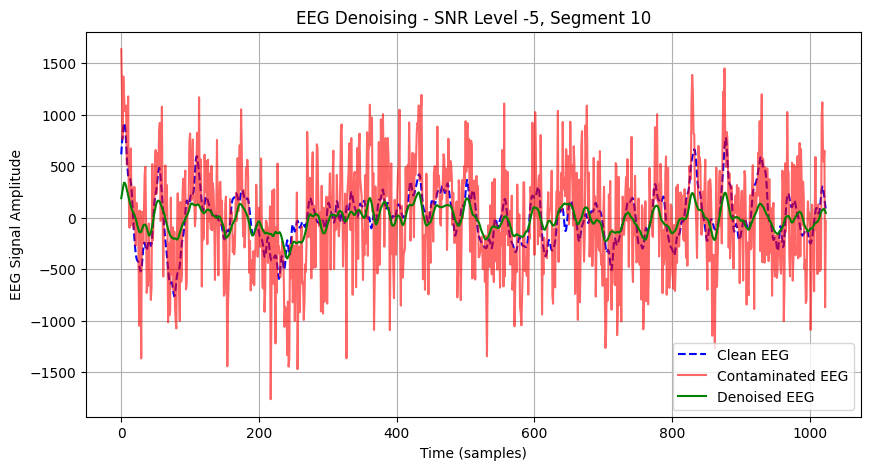

In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Select SNR level 1
snr_level = -5

# ✅ Find indices where SNR level matches
snr_indices = np.where(snr_labels_test == snr_level)[0]

# ✅ Print available indices to verify
print(f"📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
print(f"✅ SNR Level {snr_level} indices in test set: {snr_indices}")

if len(snr_indices) == 0:
    print(f"❌ No test data found for SNR Level {snr_level}, cannot plot.")
else:
    # ✅ Force selection of the first occurrence (0th segment for that SNR)
    segment_idx = snr_indices[0]

    # ✅ Extract test data
    noisy_segment = X_test[segment_idx]  # Noisy (contaminated) EEG
    clean_segment = Y_test[segment_idx]  # Clean EEG

    # ✅ Convert noisy EEG to PyTorch tensor and denoise using the model
    noisy_tensor = torch.tensor(noisy_segment, dtype=torch.float32).unsqueeze(0).to(device)
    denoised_tensor = model(noisy_tensor).cpu().detach().numpy().squeeze()

    # ✅ Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
    plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
    plt.plot(denoised_tensor, label="Denoised EEG", color="green", linewidth=1.5)

    plt.xlabel("Time (samples)")
    plt.ylabel("EEG Signal Amplitude")
    plt.title(f"EEG Denoising - SNR Level {snr_level}, Segment {segment_idx}")
    plt.legend()
    plt.grid(True)
    plt.show()


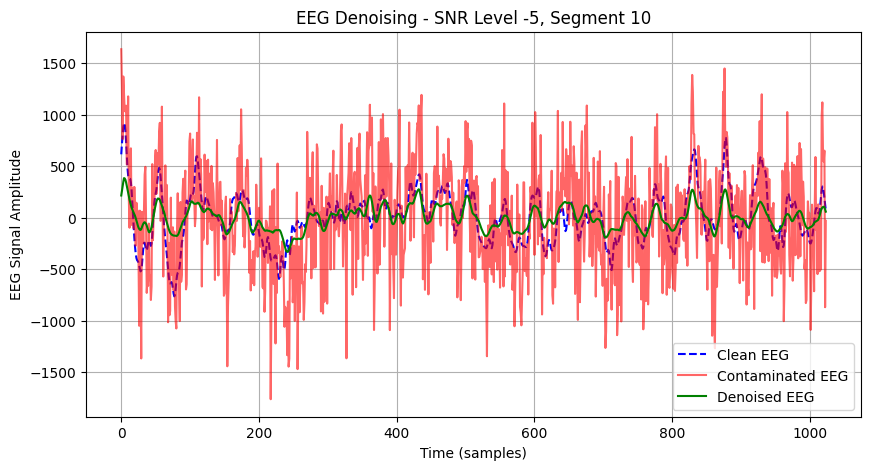

In [37]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Select SNR level 1
snr_level = -5

# ✅ Find indices where SNR level matches
snr_indices = np.where(snr_labels_test == snr_level)[0]

if len(snr_indices) == 0:
    print(f"❌ No test data found for SNR Level {snr_level}, cannot plot.")
else:
    # ✅ Select the 0th segment (first sample) from the correct SNR level
    segment_idx = snr_indices[0]

    # ✅ Extract test data
    noisy_segment = X_test[segment_idx]  # Noisy (contaminated) EEG
    clean_segment = Y_test[segment_idx]  # Clean EEG

    # ✅ Convert noisy EEG to PyTorch tensor and denoise using the model
    noisy_tensor = torch.tensor(noisy_segment, dtype=torch.float32).unsqueeze(0).to(device)
    denoised_tensor = model(noisy_tensor).cpu().detach().numpy().squeeze()

    # ✅ Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
    plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
    plt.plot(denoised_tensor, label="Denoised EEG", color="green", linewidth=1.5)

    plt.xlabel("Time (samples)")
    plt.ylabel("EEG Signal Amplitude")
    plt.title(f"EEG Denoising - SNR Level {snr_level}, Segment {segment_idx}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(denoised_tensor)))      # X-axis: time/sample index
y_points = denoised_tensor.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Denoised EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")


Denoised EEG Plotting Points:
(0, 189.50059509277344)
(1, 230.27398681640625)
(2, 272.31005859375)
(3, 308.8013916015625)
(4, 339.09808349609375)
(5, 339.36395263671875)
(6, 326.3204345703125)
(7, 305.6285095214844)
(8, 277.69500732421875)
(9, 246.12374877929688)
(10, 217.3518829345703)
(11, 188.05984497070312)
(12, 157.86477661132812)
(13, 132.43820190429688)
(14, 109.89657592773438)
(15, 88.9703598022461)
(16, 72.11005401611328)
(17, 59.150150299072266)
(18, 42.60613250732422)
(19, 29.510725021362305)
(20, 11.59914779663086)
(21, -11.874773025512695)
(22, -34.7489128112793)
(23, -65.88591003417969)
(24, -91.22900390625)
(25, -113.45599365234375)
(26, -134.96258544921875)
(27, -140.28720092773438)
(28, -141.71749877929688)
(29, -136.4453125)
(30, -114.36675262451172)
(31, -95.61810302734375)
(32, -76.9643325805664)
(33, -67.9961166381836)
(34, -66.87333679199219)
(35, -69.25566864013672)
(36, -81.11381530761719)
(37, -97.84681701660156)
(38, -123.44561767578125)
(39, -152.248718261718

In [13]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(clean_segment)))      # X-axis: time/sample index
y_points = clean_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Clean EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")


Clean EEG Plotting Points:
(0, 615.7932554229114)
(1, 717.6267552263218)
(2, 799.8013538111932)
(3, 882.2861410122889)
(4, 917.1930197835411)
(5, 917.8801140996316)
(6, 849.2282451531665)
(7, 739.8196169738147)
(8, 603.4371086945941)
(9, 486.0830983569419)
(10, 410.14348917363424)
(11, 382.2594948767313)
(12, 382.06640821380387)
(13, 377.46291170442765)
(14, 341.65988784690177)
(15, 265.3277646518784)
(16, 157.08447419133722)
(17, 34.68492595481235)
(18, -85.33228858057285)
(19, -192.61617927326898)
(20, -281.65712304942303)
(21, -348.59242260556164)
(22, -391.12796428222515)
(23, -412.0375650411734)
(24, -421.7405017650807)
(25, -434.95799570719856)
(26, -461.36861111510206)
(27, -496.5245779408668)
(28, -521.2204874357623)
(29, -512.3659417004367)
(30, -459.5452623752538)
(31, -375.67468407473206)
(32, -292.81094045986515)
(33, -244.12380552100453)
(34, -243.4585978316599)
(35, -276.6315089141078)
(36, -311.09327235793995)
(37, -317.93043936402285)
(38, -290.98621328174164)
(39, -249

In [14]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(noisy_segment)))      # X-axis: time/sample index
y_points = noisy_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Contaminated EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")


Contaminated EEG Plotting Points:
(0, 1636.3954075441677)
(1, 1255.705710942903)
(2, 763.145162023332)
(3, 1371.691123827098)
(4, 1214.4375270007038)
(5, 1036.54271380131)
(6, 1031.912178953688)
(7, 1088.3846059231291)
(8, 516.848323608457)
(9, 528.9623420523876)
(10, 1178.4521274208262)
(11, 180.10566414242564)
(12, -97.38291391773788)
(13, 483.78683678064976)
(14, 673.8637052592408)
(15, -69.82294944135248)
(16, 88.3026446643791)
(17, 291.83078528666954)
(18, -105.21915481041279)
(19, 298.98970540020775)
(20, 70.6210328678859)
(21, -272.3925714738966)
(22, 145.4081048919499)
(23, 71.37474190142154)
(24, 65.8712557834454)
(25, -339.3791782523666)
(26, -1049.3984661047689)
(27, 68.32677790660244)
(28, -593.2579383023461)
(29, -1366.8546990984973)
(30, 57.506749550279835)
(31, 1.6197674692491546)
(32, -248.10737885335286)
(33, 105.50555160344575)
(34, 417.6348198869139)
(35, 494.13622765277864)
(36, -10.535532065295001)
(37, -730.1108498466101)
(38, -599.3775831919436)
(39, -661.5515187

: 